In [195]:
import pandas as pd
import statsmodels.api as sm
import geopandas as gpd
import plotly.express as px
from stats.reg import coefplot
from data.geo import meter_to_foot
from data.constants import WEB_CRS, LOCAL_CRS
import contextily as cx

In [174]:
point_panel_in = "../../data/interim/point_panel.parquet"
line_panel_in = "../../data/interim/line_panel.parquet"
tract_panel_in = "../../data/interim/tract_panel.parquet"

poi_file_in = "../../data/raw/poi_buildings.geojson"
train_stations_in = "../../data/interim/train_stations.geojson"
train_lines_in = "../../data/raw/train_lines.geojson"
bus_routes_in = "../../data/interim/bus_routes.geojson"
bus_stops_in = "../../data/interim/bus_stops.geojson"
bike_stations_in = "../../data/interim/bike_stations_gbfs_v2.geojson"
tract_file_in = "../../data/interim/tracts.geoparquet"

point_panel = pd.read_parquet(point_panel_in)
line_panel = pd.read_parquet(line_panel_in)
tract_panel = pd.read_parquet(tract_panel_in)

pois = gpd.read_file(poi_file_in)
train_stations = gpd.read_file(train_stations_in)
train_lines = gpd.read_file(train_lines_in)
bus_routes = gpd.read_file(bus_routes_in)
bus_stops = gpd.read_file(bus_stops_in)
bike_stations = gpd.read_file(bike_stations_in)
tracts = gpd.read_parquet(tract_file_in)

In [175]:
poi_cols = list(point_panel.filter(regex="uc_|mp_").columns)
keep_cols = poi_cols + ['transit','rides','id','tid','DNC']
point_panel = point_panel.filter(keep_cols)
line_panel = line_panel.filter(keep_cols)
tract_panel = tract_panel.filter(keep_cols)

In [176]:
rides = pd.concat([point_panel, line_panel, tract_panel], keys=['point','line','tract'], names=['shape','index']).reset_index('shape')

In [177]:
rides = rides.groupby(poi_cols + ['shape','id','transit'])['rides'].sum().reset_index()

In [178]:
rides['UC400'] = (rides['uc_400'] > 0)
rides['UC800'] = (rides['uc_800'] > 0)
rides['UC1600'] = (rides['uc_1600'] > 0)
rides['MP400'] = (rides['mp_400'] > 0)
rides['MP800'] = (rides['mp_800'] > 0)
rides['MP1600'] = (rides['mp_1600'] > 0)
rides['UCMP400'] = (rides['uc_400'] > 0) | (rides['mp_400'] > 0)
rides['UCMP800'] = (rides['uc_800'] > 0) | (rides['mp_800'] > 0)
rides['UCMP1600'] = (rides['uc_1600'] > 0) | (rides['mp_1600'] > 0)
rides = rides.drop(columns=poi_cols)


# Sample Size

In [179]:
rides.drop(columns=['id','rides']).groupby(['shape','transit']).agg(['sum','mean'])
# Nevertheless, I stand by using the 1600m because there are barely enough observations in that one,
# certainly not enough in the 800 and 400m.

UC400           UC800           UC1600           MP400  \
                sum      mean   sum      mean    sum      mean   sum   
shape transit                                                          
line  bus         4  0.032000     7  0.056000     13  0.104000     2   
      train       0  0.000000     3  0.375000      3  0.375000     0   
point bike        2  0.001209     5  0.003023     27  0.016324     2   
      train       0  0.000000     3  0.020833      6  0.041667     0   
      uber        4  0.003165     9  0.007120     27  0.021361     1   
tract bike        3  0.004580     7  0.010687     22  0.033588     3   
      bus         4  0.004551     9  0.010239     27  0.030717     3   
      train       2  0.017544     5  0.043860      8  0.070175     1   
      uber        4  0.003165     9  0.007120     27  0.021361     1   

                        MP800           MP1600           UCMP400            \
                   mean   sum      mean    sum      mean     sum      mean   
shape transit                                                                
line  bus      0.016000     6  0.048000     13  0.104000       6  0.048000   
      train    0.000000     1  0.125000      2  0.250000       0  0.000000   
point bike     0.001209     7  0.004232     20  0.012092       4  0.002418   
      train    0.000000     1  0.006944      2  0.013889       0  0.000000   
      uber     0.000791     4  0.003165     13  0.010285       5  0.003956   
tract bike     0.004580     6  0.009160     15  0.022901       6  0.009160   
      bus      0.003413     6  0.006826     16  0.018203       7  0.007964   
      train    0.008772     2  0.017544      6  0.052632       3  0.026316   
      uber     0.000791     4  0.003165     13  0.010285       5  0.003956   

              UCMP800           UCMP1600            
                  sum      mean      sum      mean  
shape transit                                       
line  bus          13  0.104000       25  0.200000  
      train         3  0.375000        4  0.500000  
point bike         12  0.007255       47  0.028416  
      train         4  0.027778        8  0.055556  
      uber         13  0.010285       40  0.031646  
tract bike         13  0.019847       37  0.056489  
      bus          15  0.017065       43  0.048919  
      train         7  0.061404       14  0.122807  
      uber         13  0.010285       40  0.031646

# Sensitivity

In [180]:
uc_cols = list(rides.filter(like="UC").columns)
mp_cols = list(rides.filter(like="MP").columns)
ucmp_cols = list(rides.filter(like="UCMP").columns)
uc_cols = [x for x in uc_cols if x not in ucmp_cols]
mp_cols = [x for x in mp_cols if x not in ucmp_cols]

rhs = " + ".join(uc_cols + mp_cols)
model = sm.OLS.from_formula(f"rides ~ {rhs}", rides).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     33.39
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           7.45e-40
Time:                        16:10:10   Log-Likelihood:                -90837.
No. Observations:                6107   AIC:                         1.817e+05
Df Residuals:                    6100   BIC:                         1.817e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        1.77e+05   9124.376     19.395      0.000    1.59e+05    1.95e+05
UC400[T.True]  -9.628e+05   1.88e+05     -5.108      0.000   -1.33e+06   -5.93e+05
UC800[T.True]   1.179e+06   1.38e+05      8.534      0.000    9.08e+05    1.45e+06
UC1600[T.True]  1.019e+05   6.94e+04      1.468      0.142   -3.41e+04    2.38e+05
MP400[T.True]   4.869e+05    2.4e+05      2.026      0.043    1.57e+04    9.58e+05
MP800[T.True]   -3.65e+05   1.67e+05     -2.179      0.029   -6.93e+05   -3.67e+04
MP1600[T.True]  6.807e+05   8.84e+04      7.700      0.000    5.07e+05    8.54e+05
==============================================================================
Omnibus:                    10405.781   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13370256.969
Skew:                          11.567   Prob(JB):                         0.00
Kurtosis:                     231.055   Cond. No.                         29.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

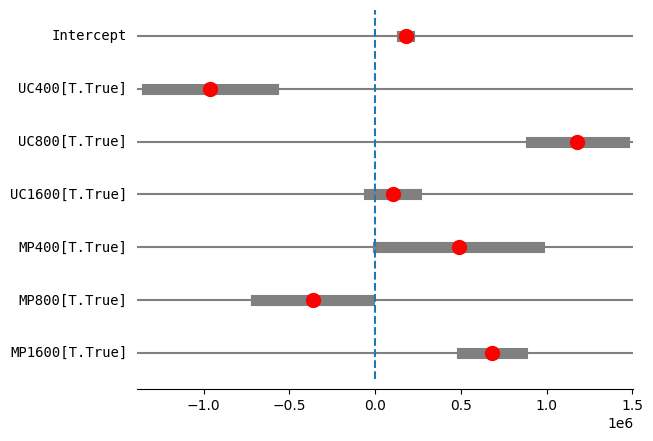

In [181]:
coefplot(model);
# Results are opposite for UC and MP. Direction is inconsistent as buffer changes.
# Indicates results are sensitive to buffer.

In [182]:
rhs = " + ".join(uc_cols + mp_cols)
model = sm.OLS.from_formula(f"rides ~ shape * ({rhs})", rides).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     44.33
Date:                Tue, 19 Nov 2024   Prob (F-statistic):          1.03e-162
Time:                        16:10:10   Log-Likelihood:                -90520.
No. Observations:                6107   AIC:                         1.811e+05
Df Residuals:                    6086   BIC:                         1.812e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      9.346e+05   6.46e+04     14.465      0.000    8.08e+05    1.06e+06
shape[T.point]                -8.875e+05   6.57e+04    -13.498      0.000   -1.02e+06   -7.59e+05
shape[T.tract]                -6.454e+05   6.58e+04     -9.805      0.000   -7.74e+05   -5.16e+05
UC400[T.True]                 -3.519e+06   4.31e+05     -8.158      0.000   -4.36e+06   -2.67e+06
UC800[T.True]                  3.505e+06   3.88e+05      9.026      0.000    2.74e+06    4.27e+06
UC1600[T.True]                 2.057e+05   2.79e+05      0.737      0.461   -3.42e+05    7.53e+05
MP400[T.True]                  1.208e+06   5.58e+05      2.166      0.030    1.15e+05     2.3e+06
MP800[T.True]                 -2.254e+06   3.84e+05     -5.874      0.000   -3.01e+06    -1.5e+06
MP1600[T.True]                  2.27e+06   2.44e+05      9.304      0.000    1.79e+06    2.75e+06
shape[T.point]:UC400[T.True]   3.196e+06   5.47e+05      5.841      0.000    2.12e+06    4.27e+06
shape[T.tract]:UC400[T.True]   2.984e+06   4.96e+05      6.019      0.000    2.01e+06    3.96e+06
shape[T.point]:UC800[T.True]   -3.13e+06   4.48e+05     -6.980      0.000   -4.01e+06   -2.25e+06
shape[T.tract]:UC800[T.True]  -2.822e+06    4.3e+05     -6.563      0.000   -3.66e+06   -1.98e+06
shape[T.point]:UC1600[T.True] -1.929e+05   2.97e+05     -0.649      0.516   -7.76e+05     3.9e+05
shape[T.tract]:UC1600[T.True] -1.668e+05   2.94e+05     -0.568      0.570   -7.43e+05    4.09e+05
shape[T.point]:MP400[T.True]  -1.095e+06   7.12e+05     -1.538      0.124   -2.49e+06    3.01e+05
shape[T.tract]:MP400[T.True]  -6.323e+05   6.41e+05     -0.987      0.324   -1.89e+06    6.23e+05
shape[T.point]:MP800[T.True]   2.223e+06   4.64e+05      4.792      0.000    1.31e+06    3.13e+06
shape[T.tract]:MP800[T.True]   1.845e+06   4.53e+05      4.075      0.000    9.58e+05    2.73e+06
shape[T.point]:MP1600[T.True] -2.228e+06   2.81e+05     -7.935      0.000   -2.78e+06   -1.68e+06
shape[T.tract]:MP1600[T.True] -1.739e+06   2.71e+05     -6.418      0.000   -2.27e+06   -1.21e+06
==============================================================================
Omnibus:                    10032.675   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10966073.626
Skew:                          10.743   Prob(JB):                         0.00
Kurtosis:                     209.480   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

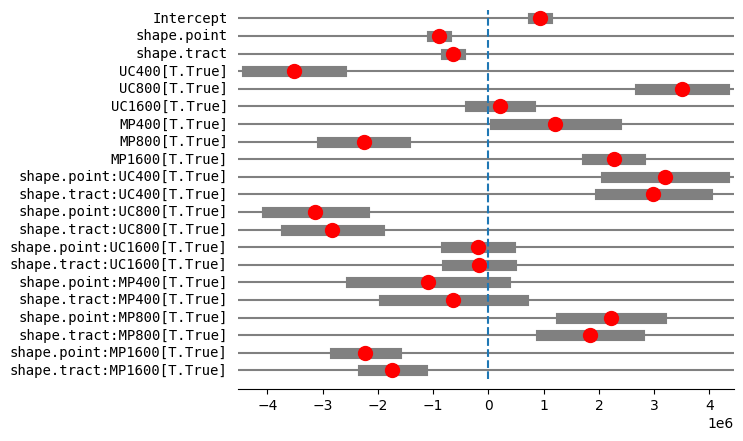

In [183]:
coefplot(model);
# Same observations hold when comparing transit types.

In [184]:
rhs = " + ".join(ucmp_cols)
model = sm.OLS.from_formula(f"rides ~ shape * ({rhs})", rides).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rides   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     69.99
Date:                Tue, 19 Nov 2024   Prob (F-statistic):          1.80e-148
Time:                        16:10:11   Log-Likelihood:                -90572.
No. Observations:                6107   AIC:                         1.812e+05
Df Residuals:                    6095   BIC:                         1.812e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        9.067e+05   6.56e+04     13.830      0.000    7.78e+05    1.04e+06
shape[T.point]                  -8.596e+05   6.67e+04    -12.887      0.000    -9.9e+05   -7.29e+05
shape[T.tract]                  -6.175e+05   6.68e+04     -9.247      0.000   -7.48e+05   -4.87e+05
UCMP400[T.True]                 -1.813e+06   3.45e+05     -5.250      0.000   -2.49e+06   -1.14e+06
UCMP800[T.True]                  7.225e+05   2.81e+05      2.569      0.010    1.71e+05    1.27e+06
UCMP1600[T.True]                 1.654e+06   1.97e+05      8.411      0.000    1.27e+06    2.04e+06
shape[T.point]:UCMP400[T.True]    1.68e+06   4.37e+05      3.841      0.000    8.22e+05    2.54e+06
shape[T.tract]:UCMP400[T.True]   1.695e+06   3.96e+05      4.276      0.000    9.18e+05    2.47e+06
shape[T.point]:UCMP800[T.True]  -5.267e+05   3.29e+05     -1.601      0.109   -1.17e+06    1.18e+05
shape[T.tract]:UCMP800[T.True]  -4.444e+05   3.18e+05     -1.399      0.162   -1.07e+06    1.78e+05
shape[T.point]:UCMP1600[T.True] -1.631e+06   2.14e+05     -7.639      0.000   -2.05e+06   -1.21e+06
shape[T.tract]:UCMP1600[T.True] -1.433e+06    2.1e+05     -6.826      0.000   -1.84e+06   -1.02e+06
==============================================================================
Omnibus:                    10262.305   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12328420.393
Skew:                          11.247   Prob(JB):                         0.00
Kurtosis:                     221.960   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

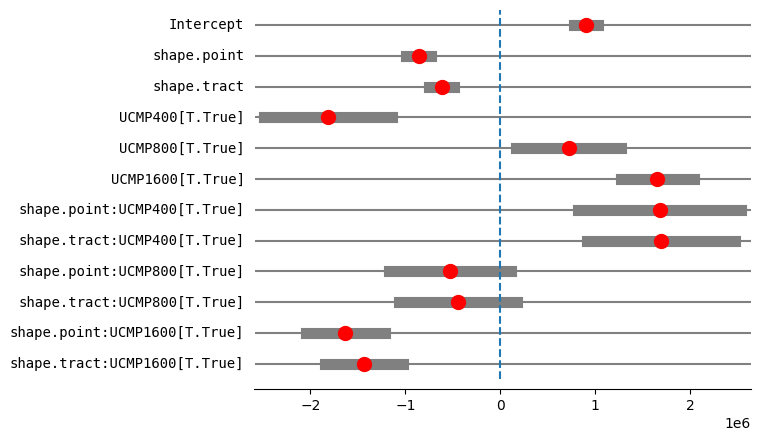

In [185]:
coefplot(model);
# Same observations hold when aggregating both POIs.

# Sample Plot

In [186]:
train_lines['line'] = train_lines['line'].str.strip()

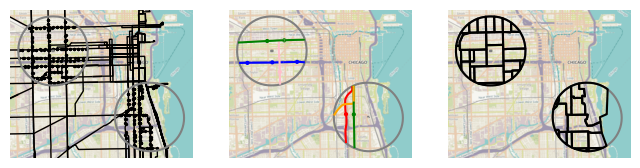

In [224]:
import matplotlib.pyplot as plt
figs, axs = plt.subplots(1,3, figsize=(8,8))
buffer = pois.to_crs(LOCAL_CRS).buffer(meter_to_foot(1600)).to_crs(WEB_CRS)
for ax in axs:
    pois.to_crs(WEB_CRS).plot(ax=ax, color='grey', zorder=2)
    buffer.boundary.plot(ax=ax, color='grey', zorder=2)
    cx.add_basemap(ax, attribution=False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

bus_stops.to_crs(WEB_CRS).clip(buffer).plot(ax=axs[0], color='black', markersize=2)
plot_bus_routes = bus_routes[bus_routes.to_crs(WEB_CRS).intersects(buffer.union_all())]
plot_bus_routes.to_crs(WEB_CRS).plot(ax=axs[0], color='black', zorder=1, linewidth=1)

plot_train_stations = train_stations.assign(color = train_stations['line'].str.split(',').apply(lambda x: x[0]))
plot_train_stations = plot_train_stations[plot_train_stations.to_crs(WEB_CRS).intersects(buffer.union_all())]
plot_train_stations.to_crs(WEB_CRS).plot(ax=axs[1], color=plot_train_stations['color'], markersize=4)

plot_train_lines = train_lines.assign(line = train_lines['line'].str.strip())
plot_train_lines = plot_train_lines.to_crs(WEB_CRS).clip(buffer)
plot_train_lines.plot(ax=axs[1], color=plot_train_lines['line'])
# sample_train_lines = plot_train_lines[plot_train_lines.to_crs(WEB_CRS).intersects(buffer.union_all())].line.unique()
# plot_train_lines = plot_train_lines[plot_train_lines.line.isin(sample_train_lines)]
# plot_train_lines.to_crs(WEB_CRS).plot(ax=axs[1], color=plot_train_lines['line'])

tracts.to_crs(WEB_CRS).clip(buffer).boundary.plot(ax=axs[2], color='black');
plt.savefig("../../reports/replication/panel_sample.jpeg")